In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('transactions_n100000.csv')
df.head()

,ticket_id,order_timestamp,location,item_name,item_count,lat,long
0,0x872a40,2019-02-28 18:33:00,4,shake,2,41.889047,-87.803605
1,0x872a40,2019-02-28 18:33:00,4,burger,2,41.889047,-87.803605
2,0x872a40,2019-02-28 18:33:00,4,fries,2,41.889047,-87.803605
3,0x598eb3,2019-09-18 11:59:00,5,burger,1,41.881818,-87.640234
4,0x598eb3,2019-09-18 11:59:00,5,salad,2,41.881818,-87.640234


In [7]:
#drop longtitude, latitude, ticket_id, order_timestamp
df = df.iloc[:, 2:5]

In [8]:
df

,location,item_name,item_count
0,4,shake,2
1,4,burger,2
2,4,fries,2
3,5,burger,1
4,5,salad,2
...,...,...,...
260736,9,burger,3
260737,9,salad,1
260738,9,fries,4
260739,2,burger,3


In [9]:
categorical_features = df['item_name']
categorical_features.unique()

array(['shake', 'burger', 'fries', 'salad'], dtype=object)

In [10]:
dummies = pd.get_dummies(categorical_features)
print(dummies)

        burger  fries  salad  shake
0            0      0      0      1
1            1      0      0      0
2            0      1      0      0
3            1      0      0      0
4            0      0      1      0
...        ...    ...    ...    ...
260736       1      0      0      0
260737       0      0      1      0
260738       0      1      0      0
260739       1      0      0      0
260740       0      1      0      0

[260741 rows x 4 columns]


In [11]:
df1 = pd.concat([df, dummies], axis=1)
del df1["item_name"]
df1

,location,item_count,burger,fries,salad,shake
0,4,2,0,0,0,1
1,4,2,1,0,0,0
2,4,2,0,1,0,0
3,5,1,1,0,0,0
4,5,2,0,0,1,0
...,...,...,...,...,...,...
260736,9,3,1,0,0,0
260737,9,1,0,0,1,0
260738,9,4,0,1,0,0
260739,2,3,1,0,0,0


In [12]:
df1[["location", "item_count"]] = StandardScaler().fit_transform(df1[["location", "item_count"]])
df1

,location,item_count,burger,fries,salad,shake
0,-0.441103,-0.335534,0,0,0,1
1,-0.441103,-0.335534,1,0,0,0
2,-0.441103,-0.335534,0,1,0,0
3,-0.050097,-1.087138,1,0,0,0
4,-0.050097,-0.335534,0,0,1,0
...,...,...,...,...,...,...
260736,1.513926,0.416070,1,0,0,0
260737,1.513926,-1.087138,0,0,1,0
260738,1.513926,1.167675,0,1,0,0
260739,-1.223114,0.416070,1,0,0,0


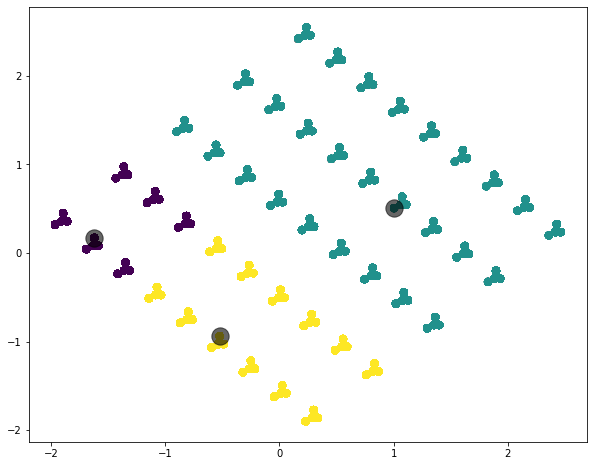

In [60]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal as mvn
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(df1)
clusters = 3
gmm = GaussianMixture(n_components=clusters, covariance_type='full').fit(Y_sklearn)
prediction_gmm = gmm.predict(Y_sklearn)
probs = gmm.predict_proba(Y_sklearn)

centers = np.zeros((clusters,2))
for i in range(clusters):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(Y_sklearn)
    centers[i, :] = Y_sklearn[np.argmax(density)]

plt.figure(figsize = (10,8))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction_gmm ,s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture as GMM
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 8

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    plt.title("GMM with %d components"%len(gmm.means_), fontsize=(20))
    plt.xlabel("U.A.")
    plt.ylabel("U.A.")
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

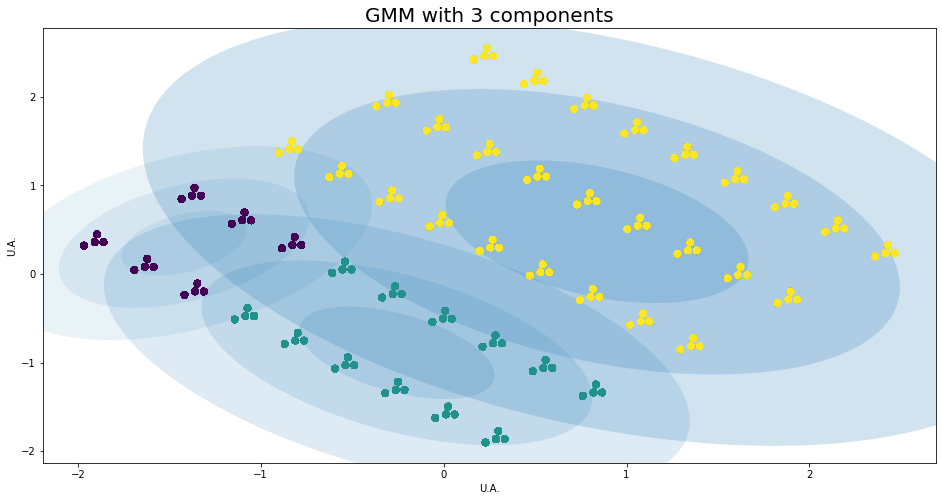

In [65]:
plot_gmm(gmm, Y_sklearn)

In [68]:
#But do we really want to use 3 clusters?
n_clusters=np.arange(2, 6)
bics=[]
bics_err=[]
iterations=6
for n in n_clusters:
    tmp_bic=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(Y_sklearn) 
        
        tmp_bic.append(gmm.bic(Y_sklearn))
    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
    err=np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)

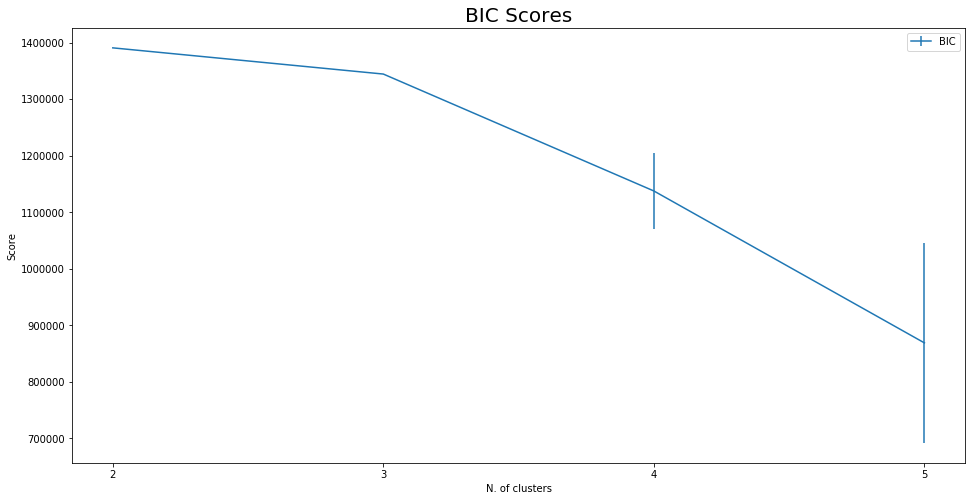

In [69]:
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

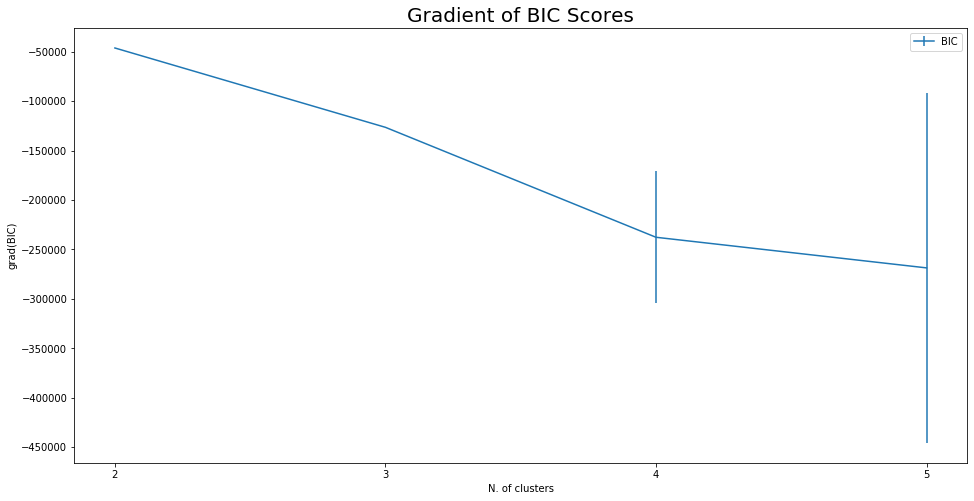

In [70]:
plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("grad(BIC)")
plt.legend()

In [ ]:
#Since we want to maximize the gradient as reasonably as possibly without using too many clusters (to make things simpler),
#then 2 clusters is the best.

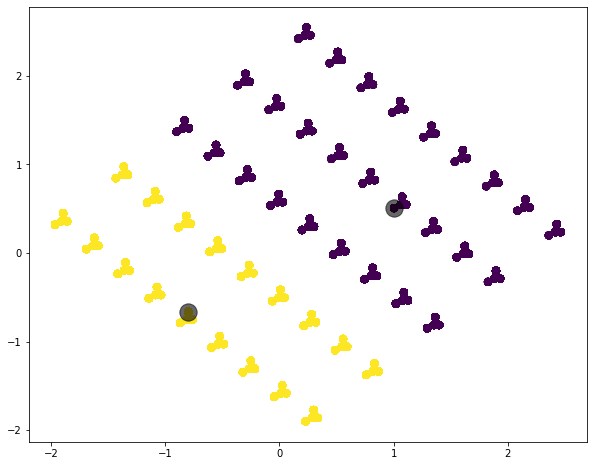

In [71]:
clusters = 2
gmm = GaussianMixture(n_components=clusters, covariance_type='full').fit(Y_sklearn)
prediction_gmm = gmm.predict(Y_sklearn)
probs = gmm.predict_proba(Y_sklearn)

centers = np.zeros((clusters,2))
for i in range(clusters):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(Y_sklearn)
    centers[i, :] = Y_sklearn[np.argmax(density)]

plt.figure(figsize = (10,8))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction_gmm, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=300, alpha=0.6);

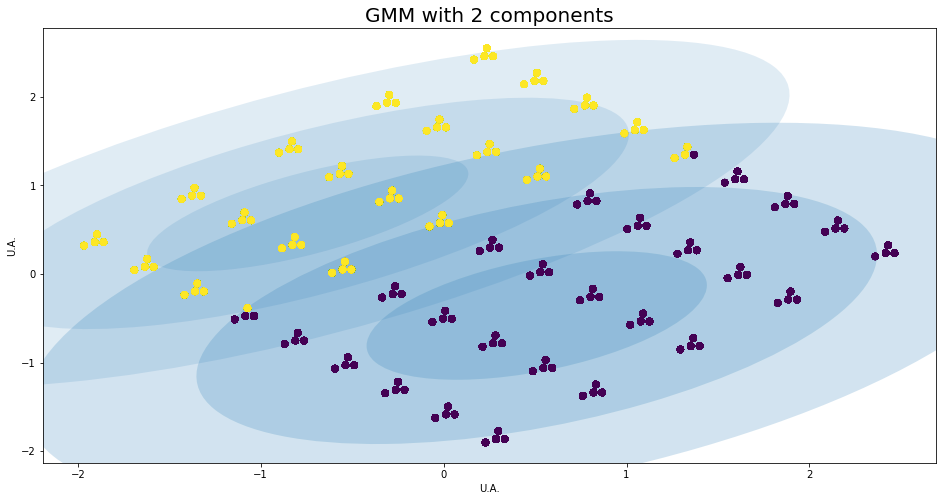

In [72]:
plot_gmm(gmm, Y_sklearn)

In [33]:
sklearn_pca.components_

array([[ 0.70141596,  0.70869617, -0.00083645,  0.01184647, -0.05824846,
         0.04723843],
       [-0.7099204 ,  0.69801172, -0.01275534,  0.07662037, -0.05090494,
        -0.01296009]])

In [61]:
def visualize_components(components, feature_x, n_components, ):
    fig = plt.figure(figsize=(15, 15))
    ax = plt.subplot()
    ax.imshow(components.T)
    ax.set_yticks(np.arange(0, len(feature_x)))
    ax.set_yticklabels(feature_x, fontsize=15)
    ax.set_xticks(np.arange(0, n_components))
    ax.set_xticklabels([i + 1 for i in range(n_components)], fontsize=15)
    ax.set_xlabel('Components', fontsize=15)
    ax.set_ylabel('Features', fontsize=15)
    pos = ax.imshow(components.T, interpolation='none')
    fig.colorbar(pos, ax=ax)
    plt.show()

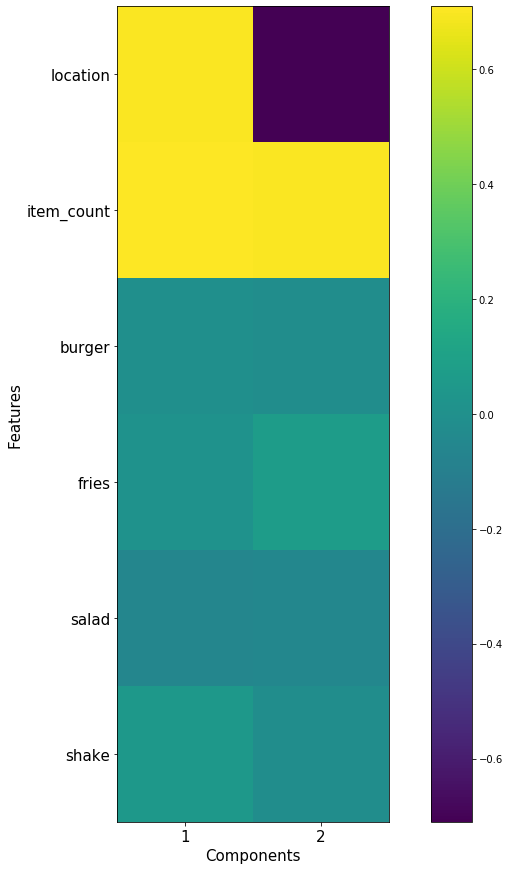

In [62]:
visualize_components(sklearn_pca.components_, df1.columns, 2)

In [73]:
df1['pred'] = pd.Series(prediction_gmm, index=df1.index)
df1

,location,item_count,burger,fries,salad,shake,pred
0,-0.441103,-0.335534,0,0,0,1,1
1,-0.441103,-0.335534,1,0,0,0,1
2,-0.441103,-0.335534,0,1,0,0,1
3,-0.050097,-1.087138,1,0,0,0,1
4,-0.050097,-0.335534,0,0,1,0,1
...,...,...,...,...,...,...,...
260736,1.513926,0.416070,1,0,0,0,0
260737,1.513926,-1.087138,0,0,1,0,1
260738,1.513926,1.167675,0,1,0,0,0
260739,-1.223114,0.416070,1,0,0,0,0


In [96]:
df = pd.read_csv('transactions_n100000.csv')
df_final = df.copy()
df_final['pred'] = df1['pred']
df_final

,ticket_id,order_timestamp,location,item_name,item_count,lat,long,pred
0,0x872a40,2019-02-28 18:33:00,4,shake,2,41.889047,-87.803605,1
1,0x872a40,2019-02-28 18:33:00,4,burger,2,41.889047,-87.803605,1
2,0x872a40,2019-02-28 18:33:00,4,fries,2,41.889047,-87.803605,1
3,0x598eb3,2019-09-18 11:59:00,5,burger,1,41.881818,-87.640234,1
4,0x598eb3,2019-09-18 11:59:00,5,salad,2,41.881818,-87.640234,1
...,...,...,...,...,...,...,...,...
260736,0x3c0582,2019-05-27 17:06:00,9,burger,3,41.524598,-87.849468,0
260737,0x3c0582,2019-05-27 17:06:00,9,salad,1,41.524598,-87.849468,1
260738,0x3c0582,2019-05-27 17:06:00,9,fries,4,41.524598,-87.849468,0
260739,0x104597,2019-12-10 00:25:00,2,burger,3,42.049306,-87.677606,0


In [97]:
two_cluster_pred = df_final.to_csv('two_cluster_pred.csv', index = True)